In [1]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import findsources as find
plt.style.use('mplstyle')


In [2]:
# with fits.open('final_mosaic.pybdsf.srl.fits') as hdul:
#     data = hdul[1].data
# original_fluxes = np.array(data['Total_flux'])

In [3]:
# Load GLEAM catalog
gleam_catalog = "GLEAM_EGC_v2.fits.gz"
# gleamx1_catalog = "VIII_110_catalog.dat.gz.fits"
gleamx1_catalog = "VIII_113_catalog2.dat.gz.fits"
tgss_catalog = "TGSSADR1_7sigma_catalog.fits"
pybdsf_catalog= "final_mosaic.pybdsf.srl.fits"
# pybdsf_catalog= "final_mosaicadaptive.pybdsf.srl.fits"
nvss_catalog= "nvss_catalog.fits"

In [4]:
target_ra_hms = '02h00m12s'
target_dec_dms = '-30d53m24s'
search_radius = 100 * 3600 * u.arcsec

# --- Read original fluxes to define bins ---
with fits.open(pybdsf_catalog) as hdul:
    orig_data = hdul[1].data
original_fluxes = np.array(orig_data['Total_flux'])

# Define flux range and bins
# flux_min, flux_max = 0.01, 20  # Jy; adjust as needed
flux_min, flux_max = original_fluxes.min(), original_fluxes.max()

flux_thresh = flux_min/1.1 # Jy
# Set matching radius (e.g., 45 arcseconds for GLEAM-X resolution)
# match_radius = beam_size * u.arcsec
match_radius = 25 * u.arcsec
# si = -0.8

In [5]:
len(original_fluxes)

640

In [6]:
# target_ra_hms = '02h00m12s'
# target_dec_dms = '-30d53m24s'
# search_radius = 6 * 3600 * u.arcsec
# flux_thresh = 0.01 # Jy
# # Set matching radius (e.g., 45 arcseconds for GLEAM-X resolution)
# match_radius = 24 * u.arcsec
# si = -0.8

# # Load GLEAM catalog
# gleam_catalog = "GLEAM_EGC_v2.fits.gz"
# tgss_catalog = "TGSSADR1_7sigma_catalog.fits"
# pybdsf_catalog= "final_mosaic.pybdsf.srl.fits"

In [7]:
# with fits.open(pybdsf_catalog) as hdul:
#    print(hdul[1].columns)   # RA in degrees

In [8]:
# with fits.open(pybdsf_catalog) as hdul:
#     ra = hdul[1].data["RA"]   # RA in degrees
#     dec = hdul[1].data["DEC"]  # DEC in degrees
#     peak_flux = hdul[1].data["Peak_flux"]  # Total flux density
#     peak_flux_err = hdul[1].data["E_Peak_flux"]  # Flux error (check column name)
#     int_flux = hdul[1].data["Total_flux"]  # Total flux density
#     int_flux_err = hdul[1].data["E_Total_flux"]  # Total flux density
#     local_rms = hdul[1].data["Isl_rms"]  # Flux error (check column name)

In [9]:
# with fits.open(tgss_catalog) as hdul:
#     ra = hdul[1].data["RA"]   # RA in degrees
#     dec = hdul[1].data["DEC"]  # DEC in degrees
#     peak_flux = hdul[1].data["Peak_flux"]  # Total flux density
#     peak_flux_err = hdul[1].data["E_Peak_flux"]  # Flux error (check column name)
#     int_flux = hdul[1].data["Total_flux"]  # Total flux density
#     int_flux_err = hdul[1].data["E_Total_flux"]  # Total flux density
#     local_rms = hdul[1].data["RMS_noise"]  # Flux error (check column name)

In [10]:
ra, dec, peak_flux, peak_flux_err, int_flux, int_flux_err, local_rms = find.find_sources_peak_int(flux_thresh, target_ra_hms, 
                                                                                                  target_dec_dms, search_radius, 
                                                                                                  name='pybdsf')

# Compute SNR and flux ratio
snr = peak_flux / local_rms  
flux_ratio = int_flux / peak_flux  
log_flux_ratio = np.log10(flux_ratio)  

# Compute flux ratio uncertainty following Chakraborty et al. (2019, Eq. 3)
flux_ratio_uncertainty = 2 * np.sqrt((int_flux_err / int_flux) ** 2 + (peak_flux_err / peak_flux) ** 2)

# Classify sources: Extended vs. Point-like
extended = log_flux_ratio > flux_ratio_uncertainty
point_like = ~extended

In [11]:
np.sum(point_like), np.sum(extended), np.sum(point_like)+ np.sum(extended)

(476, 164, 640)

In [12]:
np.sum(extended)/(np.sum(point_like)+ np.sum(extended))

0.25625

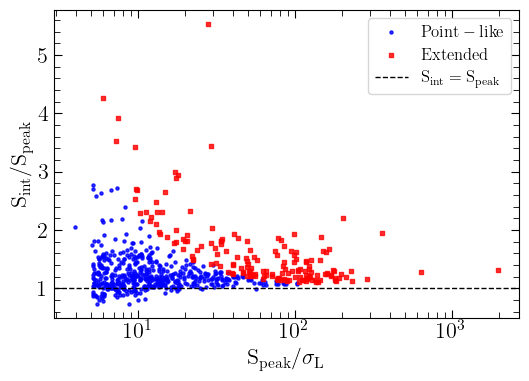

In [13]:
# # Sort SNR before plotting anything
# sorted_indices = np.argsort(snr)
# snr_sorted = snr[sorted_indices]
# flux_ratio_sorted = flux_ratio[sorted_indices]
# log_flux_ratio_sorted = log_flux_ratio[sorted_indices]
# flux_ratio_uncertainty_sorted = flux_ratio_uncertainty[sorted_indices]

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(snr[point_like], flux_ratio[point_like], 
           color='b', s=5, marker='o', alpha=0.8, label=r'$\rm Point-like$')
ax.scatter(snr[extended], flux_ratio[extended], 
           color='red', s=8, marker='s', alpha=0.8, label=r'$\rm Extended$')

# # 2-sigma noise line
# sigma_threshold_sorted = 1 + 2 * flux_ratio_uncertainty_sorted

# # Plot the 2-sigma noise line correctly
# ax.plot(snr_sorted, sigma_threshold_sorted, color='blue', linestyle='--', linewidth=1.5, label=r'$\rm 2\sigma~Boundary$')

# Axes formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\rm S_{\rm peak} / \sigma_L $')
ax.set_ylabel(r'$\rm S_{\rm int} / S_{\rm peak} $')

# Reference line at S_int / S_peak = 1
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label=r'$\rm S_{int} = S_{peak}$')
# ax.axhline(y=1.06, color='black', linestyle='--', linewidth=1, label=r'$\rm S_{int} = S_{peak}$')

# Grid and legend
ax.legend(fontsize=12, loc='upper right')

# Save high-resolution figure
plt.savefig("flux_ratio_vs_snr.pdf", bbox_inches='tight')

In [14]:
%

UsageError: Line magic function `%` not found.
